In [89]:
from pyomo.environ import *
from pyomo.dae import *
import numpy as np

1. Solution with Manual discretization

In [96]:
m = ConcreteModel() 
t = np.linspace(0, 24, 25)
m.t = ContinuousSet(initialize=t)
m.x = Var(m.t)
m.ht = Param(initialize=1)

m.dxdt = Var(m.t)

## Define the ODE equation
def _ode(m, k):
    return m.dxdt[k]==5*m.x[k] - 3 

## Define the discretization scheme
def _ode_discr(m, k):
    if k==0:
        return Constraint.Skip
    return m.x[k] == m.x[k-1] + m.ht*m.dxdt[k-1]

def _initial_cond(m):
    return m.x[0]==0.2  
m.initial_cond = Constraint(rule=_initial_cond) 

sol=[]  ## Solution storage

# Iterative solve()
for t in m.t:
    if 'ode' and 'ode_discr' in m.component_map():
        m.del_component(m.ode)
        m.del_component(m.ode_discr)
    m.ode = Constraint(m.t, rule=_ode)
    m.ode_discr = Constraint(m.t, rule=_ode_discr) 
    solver = SolverFactory("glpk")
    solver.solve(m, tee=False) 
    sol.append(value(m.x[t]))
print(sol)

[0.2, -1.8, -13.8, -85.8, -517.8, -3109.8, -18661.8, -111973.8, -671845.8, -4031077.8, -24186469.8, -145118821.8, -870712933.8, -5224277605.8, -31345665637.8, -188073993829.8, -1128443962981.8, -6770663777893.8, -40623982667365.8, -243743896004198.0, -1462463376025190.0, -8774780256151140.0, -5.26486815369069e+16, -3.15892089221441e+17, -1.89535253532865e+18]


2. Solution with Automatic discretization

In [98]:
m = ConcreteModel()
m.t = ContinuousSet(bounds=(0,24))
m.x = Var(m.t)

m.dxdt = DerivativeVar(m.x, wrt=m.t)

def _ode(m, k):
    return m.dxdt[k]==5*m.x[k] - 3
m.ode = Constraint(m.t, rule=_ode)

def _initial_cond(m):
    return m.x[0]==0.2  
m.initial_cond = Constraint(rule=_initial_cond) 

m.obj = 1

discretizer = TransformationFactory("dae.finite_difference")
discretizer.apply_to(m, nfe = 24, scheme="FORWARD")


solver = SolverFactory('glpk')
result = solver.solve(m)

3. Analytical solution

In [92]:
import numpy as np
def x(t):
    return (-0.4)*np.exp(5*t) + (0.6) 
t = np.linspace(0, 24, 25)    ## h = (b-a)/(N-1)
sol1 = x(t)

4. Solution plotting

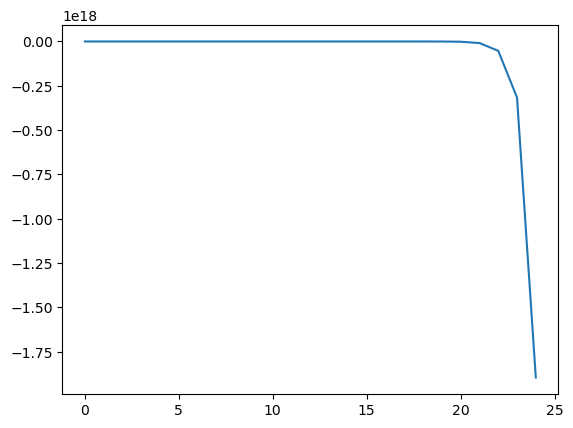

In [93]:
from matplotlib import pyplot as plt
# plt.plot(t, sol1)
plt.plot(t, sol)